# Walkthrough - RBIG

In [1]:
import sys
sys.path.append("../")

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.information.reduction import information_reduction
from rbig_jax.plots.info import plot_total_corr
from rbig_jax.plots.joint import plot_joint
from rbig_jax.plots.prob import plot_joint_prob
from rbig_jax.transforms.gaussian import init_params
from rbig_jax.transforms.rbig import rbig_init

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

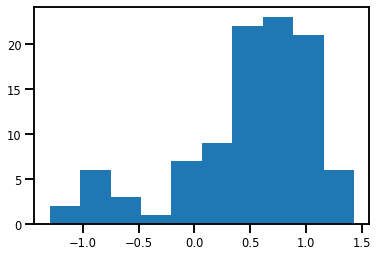

In [2]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

In [3]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


W&B Run: https://app.wandb.ai/emanjohnson91/rbigjax-demo-2d/runs/uso9ladl

In [4]:

# config parameters
wandb.config.n_samples = 10_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


## Data

In [5]:
def plot_joint(data, color: str = "red", title: str = "", kind="kde", logger=None):

    plt.figure()
    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    

def plot_joint_prob(data, probs, cmap="Reds", title="", logger=None):

    fig, ax = plt.subplots()
    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap=cmap)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(h,)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

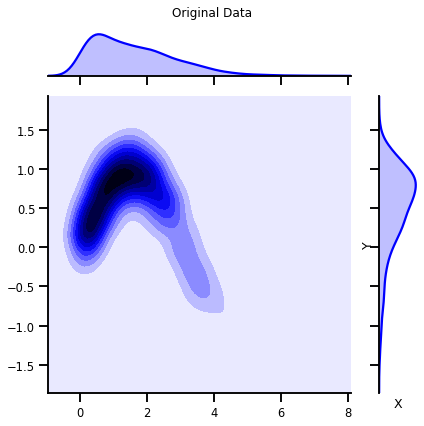

In [6]:
# %%wandb
# get data
data = get_classic(1_000)

# plot data
plot_joint(data, "blue", "Original Data", logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [7]:
from rbig_jax.transforms.rbig import forward_transform, inverse_transform

In [8]:
# get the init function
fit_forward_func = rbig_init(
    method="histogram",
    support_ext=10,
    precision=50,
    alpha=1e-5
)

In [9]:
# fit forward function
Xtrans, ldX, params = fit_forward_func(data)

# forward function
Xtrans_, ldX_ = forward_transform(params, data)

# checks to make sure they're the same
chex.assert_tree_all_close(Xtrans, Xtrans_, rtol=1e-5)
chex.assert_tree_all_close(ldX, ldX_, rtol=1e-5)
chex.assert_shape(Xtrans, (1_000, 2))

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


<Figure size 432x288 with 0 Axes>

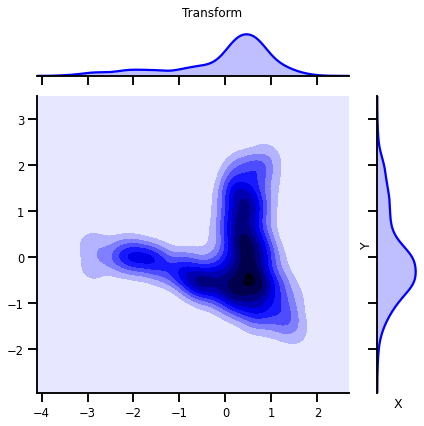

In [10]:
plot_joint(Xtrans, "blue", "Transform", logger=False)

### Inverse Transformation

In [11]:
data_ = inverse_transform(params, Xtrans)

chex.assert_tree_all_close(data_, data, rtol=1e-5)

<Figure size 432x288 with 0 Axes>

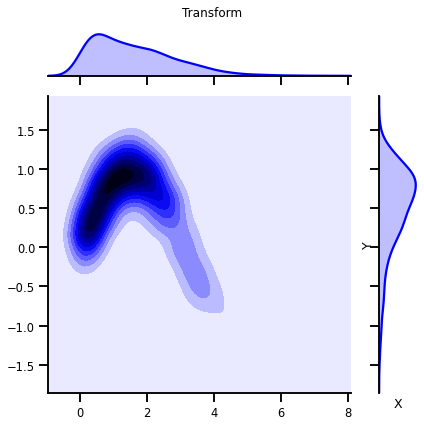

In [12]:
plot_joint(data_, "blue", "Transform", logger=False)

### Speed

We can use the `jit` method to speed up our code considerably. We simply need to jit our forward function and our inverse function.

#### Non-Jitted

In [13]:
%timeit Xtrans, ldX, params = fit_forward_func(data)
%timeit _ = forward_transform(params, data)
%timeit _ = inverse_transform(params, Xtrans)

279 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
550 µs ± 9.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
546 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Jitted

In [14]:
# get the init function
fit_forward_func = rbig_init(
    method="histogram",
    support_ext=10,
    precision=100,
    alpha=1e-5
)
fit_forward_func_jitted = jax.jit(fit_forward_func)
Xtrans, ldX, params = fit_forward_func_jitted(data)
forward_func_jitted = jax.jit(forward_transform)
inverse_func_jitted = jax.jit(inverse_transform)

In [15]:
%timeit _ = fit_forward_func_jitted(data)
%timeit _ = forward_func_jitted(params, data)
%timeit _ = inverse_func_jitted(params, Xtrans)

1.02 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
317 µs ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
233 µs ± 47.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Training

So now we have our step function and we need some kinda of condition. We will do 3 conditions:

1. We need a maximum number of layers
2. We need a minimum number of layers
3. We need no changes between a running loss

## State

In [16]:
from collections import namedtuple

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 

        "info_loss", # information loss
        "params",
        "X",
        "Xldj"
    ]
)


## Stopping Criteria

In [17]:
max_layers = 100
min_layers = 10
threshold = 0.25
tol_layers = 50


def condition_fun(state):
    # stopping criterial
    stop_crit = jax.lax.bitwise_and(
        jax.lax.bitwise_not(state.n_layers < min_layers), 
        state.n_layers > max_layers
    )
    stop_crit = jax.lax.bitwise_not(stop_crit)
    return stop_crit
#     # information loss criteria
#     if state.n_layers > tol_layers:
#         return stop_crit
#     else:
#         info_crit = state.info_loss[-tol_layers:].sum() == 0.0
#         return np.logical_or(stop_crit, info_crit) 

### Condition 1

We have `n_layers=1`. 

In [18]:
train_state = TrainState(
    n_layers=0,
    info_loss=[],
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

condition_fun(train_state)

DeviceArray(True, dtype=bool)

#### Condition 2

In [19]:
train_state = TrainState(
    n_layers=15,
    info_loss=[],
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

condition_fun(train_state)

DeviceArray(True, dtype=bool)

#### Condition 3

In [20]:
train_state = TrainState(
    n_layers=150,
    info_loss=[],
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

condition_fun(train_state)

DeviceArray(False, dtype=bool)

### 3 - Training Loop

In [21]:
data = get_classic(10_000)
data = np.array(onp.random.randn(10_000, 10))

train_state = TrainState(
    n_layers=0,
    info_loss=[],
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

def body(train_state):
    X, Xldj, params = fit_forward_func(train_state.X)

    # calculate the information loss
    it = information_reduction(train_state.X, X)

    train_state = TrainState(
        n_layers=train_state.n_layers + 1,
        info_loss=train_state.info_loss + [it],
        params=train_state.params + [params],
        X=X,
        Xldj=train_state.Xldj + Xldj
    )
    return train_state
#     return train_state._replace(
#         n_layers=train_state.n_layers + 1,
#         info_loss=train_state.info_loss + [it],
#         params = train_state.params + [params],
#         X=X,
#         Xldj=train_state.Xldj + Xldj
#     )

it_jitted = jax.jit(information_reduction)
def body_jitted(train_state):
    X, Xldj, params = fit_forward_func_jitted(train_state.X)

    # calculate the information loss
    it = it_jitted(train_state.X, X)

    train_state = TrainState(
        n_layers=train_state.n_layers + 1,
        info_loss=train_state.info_loss + [it],
        params=train_state.params + [params],
        X=X,
        Xldj=train_state.Xldj + Xldj
    )
    return train_state
#     return train_state._replace(
#         n_layers=train_state.n_layers + 1,
#         info_loss=train_state.info_loss + [it],
#         params = train_state.params + [params],
#         X=X,
#         Xldj=train_state.Xldj + Xldj
#     )

In [22]:
%%time
# # define states
# train_state = TrainState(
#     n_layers=0,
#     info_loss=[],
#     params=[],
#     X=data,
#     Xldj=np.zeros(data.shape)
    
# )

# # while loop
# t0 = time.time()
# while condition_fun(train_state):
#     train_state = body(train_state)
# print(f"Time Taken: {(time.time() - t0):.4f}")

# while loop
# define states
train_state = TrainState(
    n_layers=0,
    info_loss=[],
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

while condition_fun(train_state):
#     print(train_state.n_layers)
    train_state = body_jitted(train_state)


CPU times: user 32.6 s, sys: 2min 18s, total: 2min 51s
Wall time: 17.9 s


In [ ]:
plot_joint(train_state.X[:, :1])

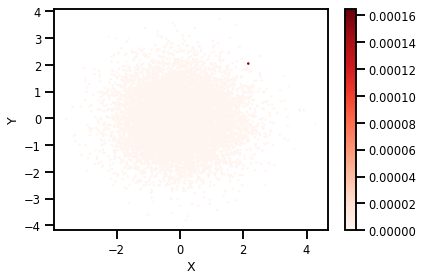

In [26]:
log_prob = (jax.scipy.stats.norm.logpdf(train_state.X) + train_state.Xldj).sum(axis=1)


plot_joint_prob(data, np.exp(log_prob), cmap='Reds', logger=None)

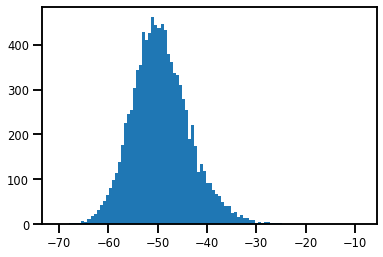

In [27]:

plt.hist(log_prob, bins=100);

#### Forward Transformation

In [ ]:
t0 = time.time()
init_val = data
for iparam in train_state.params:
    X, _ = forward_transform(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")
    
t0 = time.time()
init_val = data
for iparam in train_state.params:
    X, _ = forward_func_jitted(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")

<Figure size 432x288 with 0 Axes>

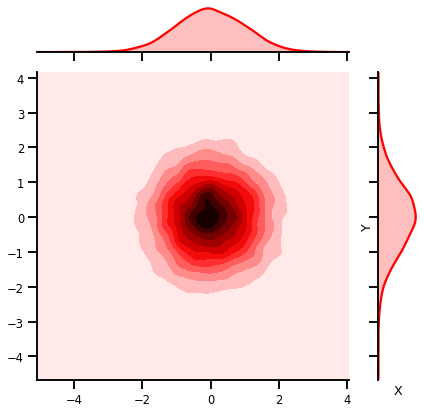

In [29]:
plot_joint(init_val)

#### Reverse Transformation

In [ ]:
t0 = time.time()
init_val = train_state.X
for iparam in reversed(train_state.params):
    X = inverse_transform(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")


t0 = time.time()
init_val = train_state.X
for iparam in reversed(train_state.params):
    X = inverse_func_jitted(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")



<Figure size 432x288 with 0 Axes>

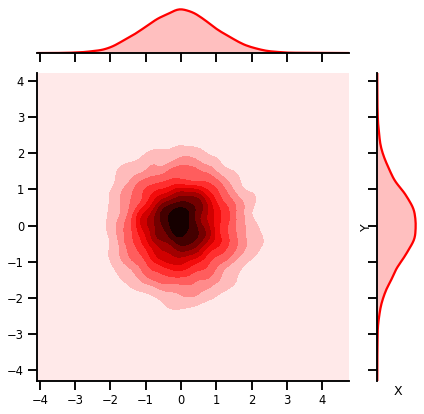

In [31]:
plot_joint(init_val)

In [32]:
train_state.n_layers

101

In [38]:
max_layers = 100
min_layers = 10
threshold = 0.25
tol_layers = 50


def condition_fun(state):
    # stopping criterial
    stop_crit = jax.lax.bitwise_and(
        jax.lax.bitwise_not(state[0] < min_layers), 
        state[0] > max_layers
    )
    stop_crit = jax.lax.bitwise_not(stop_crit)
    return stop_crit

train_state = (
    0, [], [], data, np.zeros(data.shape)
    
)

def body_jitted(train_state):
    n_layers, info_loss, params, X, Xldj = train_state
    Xtrans, Xldjtrans, new_params = fit_forward_func_jitted(X)

    # calculate the information loss
    it = it_jitted(X, Xtrans)


    return (
        n_layers + 1,
        info_loss.append(it),
        params.append(new_params),
        Xtrans,
        Xldj + Xldjtrans
    )

state = jax.lax.while_loop(condition_fun, body_jitted, train_state)

TypeError: body_fun output and input must have same type structure, got PyTreeDef(tuple, [*,PyTreeDef(None, []),PyTreeDef(None, []),*,*]) and PyTreeDef(tuple, [*,PyTreeDef(list, []),PyTreeDef(list, []),*,*]).

In [ ]:

# with tqdm.trange(max_layers) as pbar:
#     for i in pbar:
#         # step through
#         X, Xldj, params = fit_forward_func_jitted(train_state.X)
# #         plot_joint(X, "blue", "Transform", logger=False)
#         # calculate the information loss
#         it = information_reduction(train_state.X, X)
# #         wandb.log({"Delta Multi-Information": onp.array(it)})

#         # calculate the running total corrlation
# #         it_red.append(it)
# #         tc = np.array(it_red).sum()
# #         wandb.log({"TC": onp.array(tc)})
#         # update data and ldj
# #         X_transform = X_transform_
# #         X_ldj += iX_ldj

#         # calculate negative log likelihood
# #         nll = jax.scipy.stats.norm.logpdf(data) + X_ldj
# #         nll = -nll.sum(axis=1).mean()
#         train_state = TrainState(
#             n_layers=i,
#             info_loss=train_state.info_loss + [it],
#             params=train_state.params + [params],
#             X=X,
#             Xldj=train_state.Xldj + Xldj
#         )
# #         wandb.log({"Negative Log-Likelihood": onp.array(nll)})


/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/statsmodels/nonparametric/kernels.py:125: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

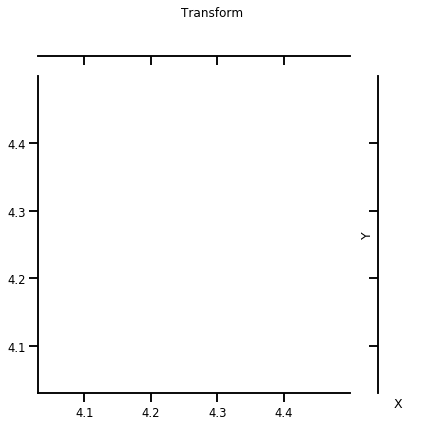

In [115]:
plot_joint(train_state.X, "blue", "Transform", logger=False)

### Speed

In [18]:
# get the init function
fit_forward_func = rbig_init(
    method="histogram",
    support_ext=10,
    precision=1000,
    alpha=1e-5
)

In [26]:
from collections import namedtuple

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
#         "h_layer1", # entropy of layer 1
#         "h_layer2", # entropy of layer 2
        "info_loss", # information loss
        "params",
        "X",
        "Xldj"
    ]
)

max_layers = 100
min_layers = 10
threshold = 0.25
tol_layers = 50


def condition_fun(state):
    # stopping criterial
    stop_crit = (
        (state.n_layers < min_layers) &
        (state.n_layers > max_layers)
    )
    return stop_crit

data = get_classic(1_000)
# data = onp.random.randn(10_000, 50)

train_state = TrainState(
    n_layers=0,
    info_loss=[],
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

def body(train_state):

    X, Xldj, params = fit_forward_func(train_state.X)

    it = information_reduction(train_state.X, X)
    train_state = TrainState(
        n_layers=train_state.n_layers + 1,
        info_loss=train_state.info_loss,
        params=train_state.params,
        X=X,
        Xldj=Xldj
    )
    return train_state

In [27]:
t = body(train_state)

0.5891896126227367


In [28]:
t

TrainState(n_layers=1, info_loss=[], params=[], X=DeviceArray([[-0.36339808, -0.44285782],
             [ 0.50357825, -1.1635399 ],
             [ 0.68222004,  0.32589687],
             ...,
             [ 0.21608003, -0.6822332 ],
             [-0.02451499,  0.46555575],
             [-0.14367929, -0.73324432]], dtype=float64), Xldj=DeviceArray([[-0.31345508,  0.68194671],
             [-0.32624642,  1.08984959],
             [ 0.31043155,  0.81871902],
             ...,
             [-0.42333794,  1.04652466],
             [-0.19230984,  0.52533583],
             [-0.35866313,  0.90912481]], dtype=float64))

In [29]:
state = jax.lax.while_loop(condition_fun, body, train_state)

Traced<ShapedArray(float64[]):JaxprTrace(level=0/0)>


In [25]:
state

TrainState(n_layers=DeviceArray(0, dtype=int64), info_loss=[], params=[], X=DeviceArray([[2.17126121, 0.63786617],
             [1.99469089, 1.05339265],
             [0.565957  , 0.71576147],
             ...,
             [1.81865403, 0.87961603],
             [0.9405275 , 0.40544533],
             [2.2228609 , 0.79822517]], dtype=float64), Xldj=DeviceArray([[0., 0.],
             [0., 0.],
             [0., 0.],
             ...,
             [0., 0.],
             [0., 0.],
             [0., 0.]], dtype=float64))

In [ ]:
from collections import namedtuple

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
#         "h_layer1", # entropy of layer 1
#         "h_layer2", # entropy of layer 2
        "info_loss", # information loss
        "params",
        "X",
        "Xldj"
    ]
)

max_layers = 100
min_layers = 10
threshold = 0.25
tol_layers = 50


def condition_fun(state):
    # stopping criterial
    stop_crit = (
        (state.n_layers < min_layers) &
        (state.n_layers > max_layers)
    )
    return stop_crit

data = get_classic(1_000)
# data = onp.random.randn(10_000, 50)

train_state = TrainState(
    n_layers=0,
    info_loss=[],
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

def body(train_state):
    n_layers, info_loss, params, X, Xldj = train_state

    Xtrans, Xldj_new, new_params = fit_forward_func(train_state.X)

    it = information_reduction(train_state.X, X)

    train_state = (
        i, info_loss.append(it),
        params.append(new_params),
        Xtrans, Xldj + Xldj_new
    )
    return train_state

In [88]:
min_l, max_l = 10, 100
n = 100
np.logical_and(not n < min_l, n > max_l)

DeviceArray(False, dtype=bool)

In [81]:
not n > min_l

True

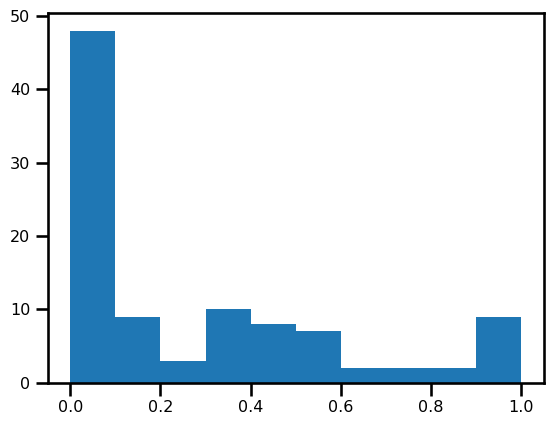

In [94]:
plt.hist(X_[:, 1], 10);